In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from scipy.stats import linregress   

from bqplot import (
    LogScale, LinearScale, ColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip
)
import bqplot.marks as bqm
from IPython.display import display
import ipywidgets as widgets

plt.style.use('ggplot')

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#This uses data from Pantheria, a database of mammals

raw_data = pd.read_csv('PanTHERIA_1-0_WR05_Aug2008.txt', sep="\t")

#Remove species with missing data
data = raw_data[np.isfinite(raw_data['5-1_AdultBodyMass_g'])]
data = data[np.isfinite(data['17-1_MaxLongevity_m'])]
data = data[np.isfinite(data['18-1_BasalMetRate_mLO2hr'])]

data['Metabolic rate/Body mass (W/g)'] = data['18-1_BasalMetRate_mLO2hr']/data['5-1_AdultBodyMass_g']
data['Lifespan Constant'] = data['17-1_MaxLongevity_m'] * data['5-1_AdultBodyMass_g'] / data['18-1_BasalMetRate_mLO2hr']
data['Lifetime expenditure of energy (W/yrs/g)'] = data['18-1_BasalMetRate_mLO2hr']/data['17-1_MaxLongevity_m']/data['5-1_AdultBodyMass_g']

#data['Log lifespan'] = np.log(data['17-1_MaxLongevity_m (yrs)'])
#data['Log body mass'] = np.log(data['5-1_AdultBodyMass_g'])
#data['Log metabolic rate'] = np.log(data['18-1_BasalMetRate_mLO2hr'])
data = data.reset_index()

#data = data[data['Class']=='Mammalia']

In [4]:
rodents = data[data['MSW05_Order']=='Rodentia']
carnivores = data[data['MSW05_Order']=='Carnivora']
bats = data[data['MSW05_Order']=='Chiroptera']
primates = data[data['MSW05_Order']=='Primates']

In [25]:
#data = data[(data['Sample size']=='large') | (data['Sample size']=='huge')]

In [5]:
data['MSW05_Order'].value_counts()

Rodentia           94
Carnivora          62
Primates           24
Diprotodontia      23
Chiroptera         22
Dasyuromorphia     19
Soricomorpha       15
Artiodactyla       12
Didelphimorphia    10
Afrosoricida        9
Pilosa              5
Cingulata           5
Erinaceomorpha      4
Lagomorpha          4
Hyracoidea          3
Macroscelidea       3
Monotremata         3
Peramelemorphia     3
Scandentia          3
Pholidota           1
Sirenia             1
Tubulidentata       1
Name: MSW05_Order, dtype: int64

# Lifespan vs. Body Mass

Text(0.5,1,'Species Body Mass vs. Lifespan')

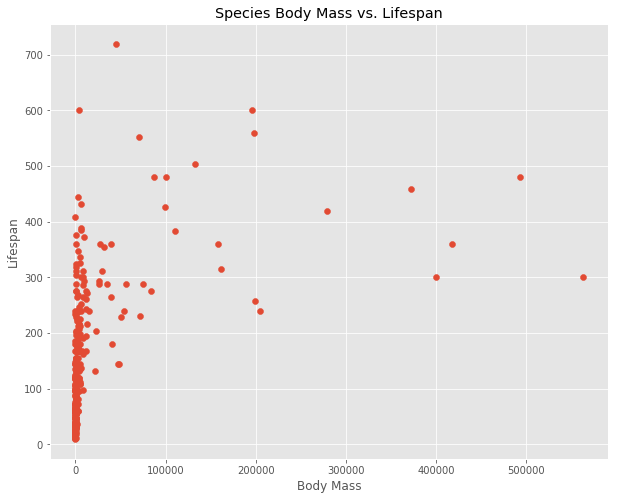

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(data['5-1_AdultBodyMass_g'], data['17-1_MaxLongevity_m'])
#plt.xlim(xmin=-2000,xmax=100000)
plt.xlabel('Body Mass (g)')
plt.ylabel('Max Lifespan (yrs)')
plt.title('Species Body Mass vs. Lifespan')

In [178]:
def update_line(change):
    lin.x = [np.min(fig_scat.x), np.max(fig_scat.x)]
    poly = np.polyfit(fig_scat.x, fig_scat.y, 1)
    lin.y = np.polyval(poly, lin.x)
    label.value = 'y = {:.2f} + {:.8f}x'.format(poly[1], poly[0])   

In [8]:
BM_min, BM_max = np.min(data['5-1_AdultBodyMass_g'].apply(np.min)), np.max(data['5-1_AdultBodyMass_g'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['17-1_MaxLongevity_m'].apply(np.min)), np.max(data['17-1_MaxLongevity_m'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Max Lifespan (months)'])

fig_scat = Scatter(x=data['5-1_AdultBodyMass_g'], y=data['17-1_MaxLongevity_m'], 
                      names=data['MSW05_Binomial'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Max Lifespan (months)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

label = widgets.Label()

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Maximum Lifespan Across Animal Species?')

box = widgets.VBox([fig])

display(box)

In [9]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['5-1_AdultBodyMass_g']), np.log(data['17-1_MaxLongevity_m']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and Lifespan: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and Lifespan: (0.21175381162626844, 0.26146671679951955)
The r^2 value for the relationship is 0.5179271460131741.
The associated p-value is 2.832829419065976e-53.


# Basal Metabolic Rate vs. Body Mass

In [30]:
def BMR_Opt(pow):
    data['Adjusted body mass'] = data['5-1_AdultBodyMass_g']**pow
    slope, intercept, r_value, p_value, std_err = linregress(data['Adjusted body mass'], data['18-1_BasalMetRate_mLO2hr'])
    #print('SE: ' + str(std_err))
    #print('Slope: ' + str(slope))
    return -r_value**2

In [31]:
from scipy.optimize import fmin
opt_BMR_pow = fmin(lambda x: BMR_Opt(x), 0.75)[0]
opt_BMR_pow

Optimization terminated successfully.
         Current function value: -0.992616
         Iterations: 12
         Function evaluations: 24


0.8612548828125002

/Users/alexyu/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/alexyu/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0,0.5,'R^2')

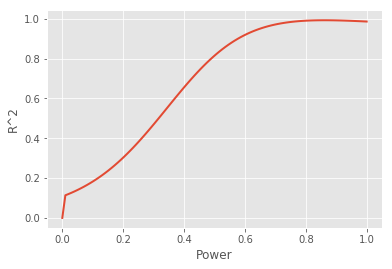

In [32]:
xvals = np.linspace(0,1,100) #100 points from 0 to 1 in ndarray
yvals = list(map(BMR_Opt, xvals)) #evaluate f for each point in xvals 

yvals = [-y for y in yvals]

plt.plot(xvals, yvals, linewidth=2.0)
plt.xlabel('Power')
plt.ylabel('R^2')

# Metabolic Rate vs. Body Mass

Note: the asiatic elephant is an influential point

Text(0.5,1,'Species Metabolic Rate vs. Body Mass')

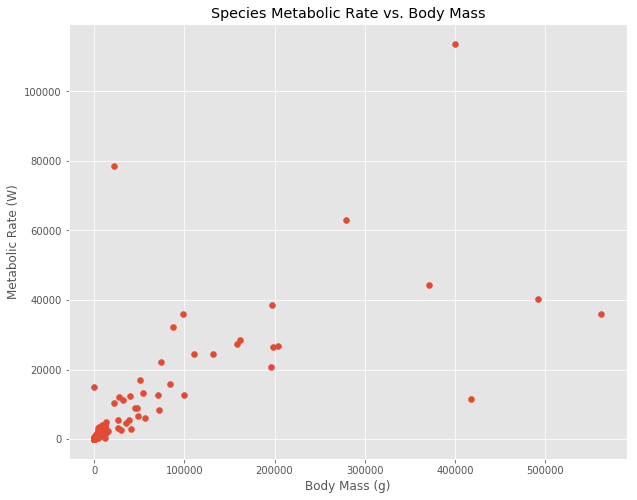

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(data['5-1_AdultBodyMass_g'], data['18-1_BasalMetRate_mLO2hr'])
#plt.xlim(xmin=-10000,xmax=500000)
#plt.ylim(ymin=-10,ymax=400)
plt.xlabel('Body Mass (g)')
plt.ylabel('Metabolic Rate (W)')
plt.title('Species Metabolic Rate vs. Body Mass')

In [13]:
BM_min, BM_max = np.min(data['5-1_AdultBodyMass_g'].apply(np.min)), np.max(data['5-1_AdultBodyMass_g'].apply(np.max))
BMR_min, BMR_max = np.min(data['18-1_BasalMetRate_mLO2hr'].apply(np.min)), np.max(data['18-1_BasalMetRate_mLO2hr'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['17-1_MaxLongevity_m'].apply(np.min)), np.max(data['17-1_MaxLongevity_m'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Metabolic Rate (W)'])

fig_scat = Scatter(x=data['5-1_AdultBodyMass_g'], y=data['18-1_BasalMetRate_mLO2hr'].round(decimals = 3),
                      names=data['MSW05_Binomial'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Metabolic Rate (W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Metabolic Rate Across Animal Species?')

fig

Figure(axes=[Axis(label='Body Mass (g)', scale=LogScale(max=562592.69, min=4.2)), Axis(label='Metabolic Rate (…

In [35]:
temp = data[(data['MSW05_Binomial']!='Acrobates pygmaeus') & (data['MSW05_Binomial']!='Leptailurus servail')]

In [15]:
np.polyfit(x, y, 1)

array([0.6901258 , 1.47570547])

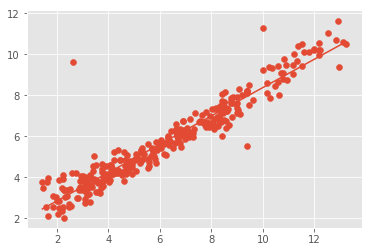

In [31]:
plt.scatter(np.log(data['5-1_AdultBodyMass_g']), np.log(data['18-1_BasalMetRate_mLO2hr']))
y = np.log(data['18-1_BasalMetRate_mLO2hr'])
x = np.log(data['5-1_AdultBodyMass_g'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

In [36]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(temp['5-1_AdultBodyMass_g']), np.log(temp['18-1_BasalMetRate_mLO2hr']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and lifespan for mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and lifespan for mammals and birds: (0.6795325331509628, 0.7181894431070611)
The r^2 value for the relationship is 0.9395726655197285.
The associated p-value is 6.755410111134553e-199.


# Testing Existence of Constants in Lifetime Energy Expenditure

Text(0.5,1,'Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

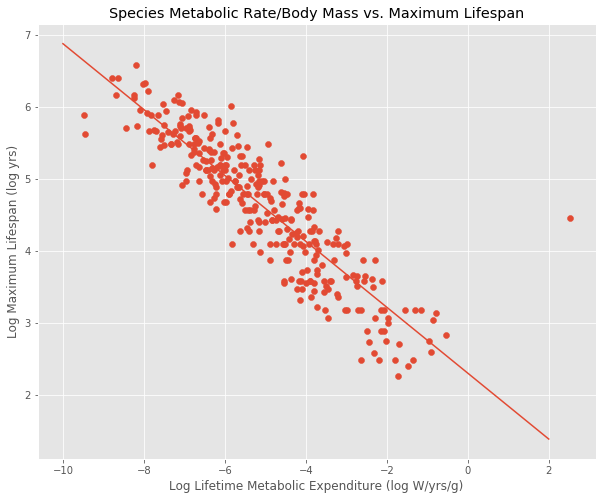

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(np.log(data['Lifetime expenditure of energy (W/yrs/g)']), np.log(data['17-1_MaxLongevity_m']))
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(-10, 2)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.ylabel('Log Maximum Lifespan (log yrs)')
plt.title('Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

In [18]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['Lifetime expenditure of energy (W/yrs/g)']), np.log(data['17-1_MaxLongevity_m']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for the slope: (-0.4833950776367207, -0.4316839484263804)
The r^2 value for the relationship is 0.7878175887010948.
The associated p-value is 4.213870640406952e-111.


Text(0.5,1,'Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

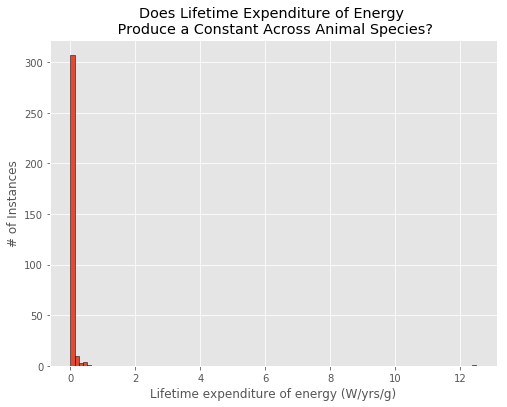

In [21]:
#temp_data = data[data['Lifespan Constant'] < 100000]
# Several outliers (11) exist past the 100,000 mark

plt.figure(figsize=(8,6))
plt.hist(data['Lifetime expenditure of energy (W/yrs/g)'], bins=100, ec="k")
plt.xlabel('Lifetime expenditure of energy (W/yrs/g)')
plt.ylabel('# of Instances')
plt.title('Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

Text(0.5,1,'Species Body Mass vs. Lifetime Energy Expenditure')

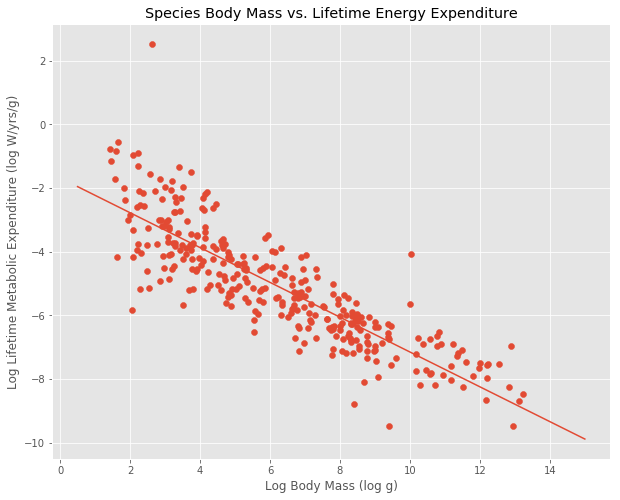

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(np.log(data['5-1_AdultBodyMass_g']), np.log(data['Lifetime expenditure of energy (W/yrs/g)']))
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(0.5, 15)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Body Mass (log g)')
plt.ylabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.title('Species Body Mass vs. Lifetime Energy Expenditure')

In [22]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['5-1_AdultBodyMass_g']), np.log(data['Lifetime expenditure of energy (W/yrs/g)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for the slope: (-0.582292457400677, -0.510676466852907)
The r^2 value for the relationship is 0.7341565683569113.
The associated p-value is 3.1794969177976404e-95.


In [24]:
BM_min, BM_max = np.min(data['5-1_AdultBodyMass_g'].apply(np.min)), np.max(data['5-1_AdultBodyMass_g'].apply(np.max))
BMR_min, BMR_max = np.min(data['18-1_BasalMetRate_mLO2hr'].apply(np.min)), np.max(data['18-1_BasalMetRate_mLO2hr'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['17-1_MaxLongevity_m'].apply(np.min)), np.max(data['17-1_MaxLongevity_m'].apply(np.max))

x_sc = LinearScale(min=BMR_min, max=BMR_max)
y_sc = LinearScale(min=lifespan_min, max=lifespan_max)
size_sc = LinearScale(min=BM_min, max=BM_max)

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', '18-1_BasalMetRate_mLO2hr', 'Maximum lifespan (months)', '5-1_AdultBodyMass_g'])

fig_scat = Scatter(x=data['18-1_BasalMetRate_mLO2hr'].round(decimals = 3), y=data['17-1_MaxLongevity_m'], size=data['5-1_AdultBodyMass_g'],
                      names=data['MSW05_Binomial'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=800, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='Metabolic Rate (W)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Maximum Lifespan (months)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='How Does Metabolic Rate Correlate with Maximum Lifespan \n in Mammals and Birds?')
fig.layout.height = '600px'
fig.layout.width = '800px'

fig

Figure(axes=[Axis(label='Metabolic Rate (W)', scale=LinearScale(max=113712.0, min=7.7)), Axis(label='Maximum L…

In [25]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['18-1_BasalMetRate_mLO2hr']), np.log(data['17-1_MaxLongevity_m']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between metabolic rate and metabolic rate in mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between metabolic rate and metabolic rate in mammals and birds: (0.2663960691754382, 0.3401657190614878)
The r^2 value for the relationship is 0.44494014996194536.
The associated p-value is 2.532707985136793e-43.


(-103.8613905985415, 100)

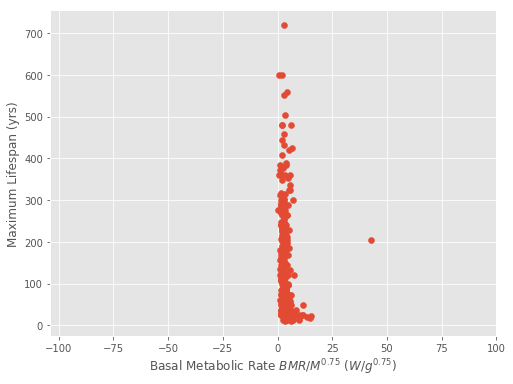

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(data['18-1_BasalMetRate_mLO2hr']/np.power(data['5-1_AdultBodyMass_g'], .75), data['17-1_MaxLongevity_m'])
plt.xlabel('Basal Metabolic Rate $BMR/M^{0.75}$ ($W/g^{0.75}$)')
plt.ylabel('Maximum Lifespan (yrs)')
plt.xlim(xmax=100)
